## Assess the impact of atmosphere on offset time-seris

Run the following `prep_*.ipynb` to generate the input time-series for this analysis:

1. prep_sar.ipynb
2. prep_era5.ipynb
3. prep_gim_tec.ipynb
4. prep_igs_tec.ipynb
5. prep_solid_earth_tide.ipynb

### Contents

0. Read data and initiate utils functions
1. SAR vs. GIM/IGS TEC
2. Residual (SAR - TEC) vs. ERA5
3. Residual (SAR - TEC - ERA5) vs. SET
4. Residual (SAR - TEC - ERA5 - SET) vs. Distance btw. SAR and TEC
5. Differential TS: Residual (SAR - TEC - ERA5) vs. SET

In [1]:
%matplotlib inline
import os
import pickle
import datetime as dt
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt, legend_handler
from mintpy.utils import plot as pp
plt.rcParams.update({'font.size': 12})
fig_size = [9, 4]

# config
n = 3                   # number of med abs dev
dt_s1ab = dt.datetime(2016, 10, 7)    # dateime separating S1A and S1B
tropo_opt = 'vHgtMed'   # cHgtCen / vHgtMed. vHgtMed is preferred due to its better match with the residual in terms of magnitude
iono_version = 2.1      # 1.0 / 2.0 / 2.1
tec_src = 'GIM'         # GIM / IGS
tec_type = 'subTEC'        # subTEC / TEC
save = True

# location of interest
#box = (85, 25, 145, 70);  box_suffix = 'boxCC'   # box to read for range offset in (x0, y0, x1, y1)
box = (10, 55, 20, 70);   box_suffix = 'boxCL'   # box in the center left with low  altitude
box = (200, 15, 215, 30); box_suffix = 'boxLR'   # box in the lower right with high altitude

# dir
proj_dir = os.path.expanduser('~/data/ChileSenAT149')
work_dir = os.path.join(proj_dir, 'offset_comp', box_suffix)
os.chdir(work_dir)
print('Go to directory', work_dir)

Go to directory /Users/yunjunz/data/ChileSenAT149/offset_comp/boxLR


### 0. Read all time-series

In [2]:
# utils function
def get_common_index(t1s, t2s):
    # get common dates
    tcomm = np.array(sorted(list(set(t1s) & set(t2s))))

    flag1 = np.zeros(t1s.size, dtype=np.bool_)
    for i in range(t1s.size):
        if t1s[i] in tcomm:
            flag1[i] = True

    flag2 = np.zeros(t2s.size, dtype=np.bool_)
    for i in range(t2s.size):
        if t2s[i] in tcomm:
            flag2[i] = True

    if not np.all(flag2):
        print('WARNING: SAR dict does not have all dates in ATMOS dict!')

    return flag1, flag2

def plot_dot_figure(x, y, xname, yname, vlim, save, out_fig):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[3, 3])
    ax.plot(x, y, 'k.')
    ax.plot(vlim, vlim, 'k--')

    # axis format
    ax.set_xlim(vlim)
    ax.set_ylim(vlim)
    ax.set_xlabel('$offset_{{{n}}}$ [m]'.format(n=xname))
    ax.set_ylabel('$offset_{{{n}}}$ [m]'.format(n=yname))
    ax.set_aspect('equal', 'box')
    fig.tight_layout()

    # output
    print('save figure to file', out_fig)
    if save:
        plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
    return

# output files from prep_*.ipynb
fDict = {
    'SAR' : os.path.join(work_dir, 'sar.pickle'),
    'GIM' : os.path.join(work_dir, 'gim_tec_v{}.pickle'.format(iono_version)),
    'IGS' : os.path.join(work_dir, 'igs_tec.pickle'),
    'ERA' : os.path.join(work_dir, 'era5.pickle'),
    'SET' : os.path.join(work_dir, 'set.pickle'),
}

# read files into dict
dDict = {}
for key, fname in fDict.items():
    with open(fname, 'rb') as f:
        dDict[key] = pickle.load(f)
        print('read {} data from pickle file: {}'.format(key, fname))

flag = get_common_index(dDict['SAR']['date'], dDict['GIM']['date'])[0]
t1      = np.array(dDict['SAR']['time'])    # All the others
t2      = np.array(dDict['GIM']['time'])    # GIM
sar     = np.array(dDict['SAR']['range_offset_med'])            # estimated offset from SAR
sar_err = np.array(dDict['SAR']['range_offset_mad']) * n
gimT    = np.array(dDict['GIM']['range_delay4Cband_TEC'])       # predicted offset from GIM TEC
gimS    = np.array(dDict['GIM']['range_delay4Cband_subTEC'])    # predicted offset from GIM TEC
gimT2   = np.array(dDict['GIM']['TEC'])
gimS2   = np.array(dDict['GIM']['subTEC'])
# somethinnp.array(g is strange on the IGS TEC, need to check more carefully.
igs     = np.array(dDict['IGS']['range_delay4Cband_TEC']) * -1  # predicted offset from IGS TEC
igs2    = np.array(dDict['IGS']['TEC']) * -1
era     = np.array(dDict['ERA']['range_delay_tropo_med'])       # predicted offset from ERA5 (dry + wet)
era_err = np.array(dDict['ERA']['range_delay_tropo_mad']) * n
sld     = np.array(dDict['SET']['range_delay_SET_med']) * -1    # predicted offset from SET
sld_err = np.array(dDict['SET']['range_delay_SET_mad']) * -1 * n

# align other data to SAR with a constant
# Notes at 2020-08-25 by ZY: tried use the median difference as yoff, not noticeable difference, thus use the 1st for simplicity
gimT -= gimT[0]
gimS -= gimS[0]
igs -= igs[0]
era -= era[0]
sld -= sld[0]

# iono datasets
tec = {}
tec['TECigs']    = {'time': t1, 'delay': igs,  'value': igs2}
tec['TECgim']    = {'time': t2, 'delay': gimT, 'value': gimT2}
tec['subTECgim'] = {'time': t2, 'delay': gimS, 'value': gimS2}

read SAR data from pickle file: /Users/yunjunz/data/ChileSenAT149/offset_comp/boxLR/sar.pickle
read GIM data from pickle file: /Users/yunjunz/data/ChileSenAT149/offset_comp/boxLR/gim_tec_v2.1.pickle
read IGS data from pickle file: /Users/yunjunz/data/ChileSenAT149/offset_comp/boxLR/igs_tec.pickle
read ERA data from pickle file: /Users/yunjunz/data/ChileSenAT149/offset_comp/boxLR/era5.pickle
read SET data from pickle file: /Users/yunjunz/data/ChileSenAT149/offset_comp/boxLR/set.pickle


### 1. SAR v.s. (sub)TEC (IGS / GIM)

ionosphere: TEC (IGS)
save figure to file /Users/yunjunz/data/ChileSenAT149/offset_comp/boxLR/TS_Sen_vs_TECigs.png
save figure to file /Users/yunjunz/data/ChileSenAT149/offset_comp/boxLR/DOT_Sen_vs_TECigs.png


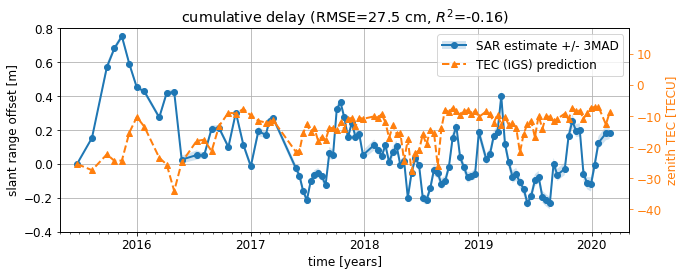

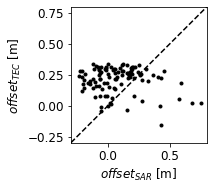

ionosphere: TEC (GIM)
save figure to file /Users/yunjunz/data/ChileSenAT149/offset_comp/boxLR/TS_Sen_vs_TECgim.png
save figure to file /Users/yunjunz/data/ChileSenAT149/offset_comp/boxLR/DOT_Sen_vs_TECgim.png


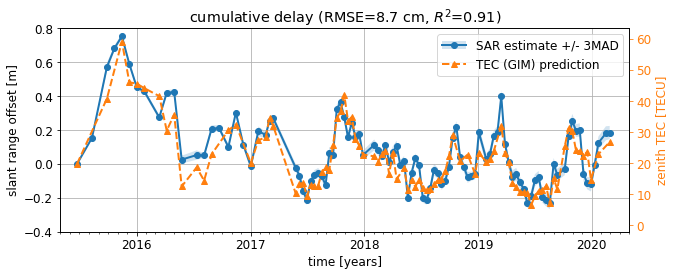

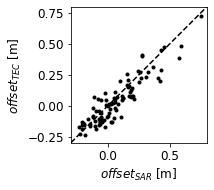

ionosphere: subTEC (GIM)
save figure to file /Users/yunjunz/data/ChileSenAT149/offset_comp/boxLR/TS_Sen_vs_subTECgim.png
save figure to file /Users/yunjunz/data/ChileSenAT149/offset_comp/boxLR/DOT_Sen_vs_subTECgim.png


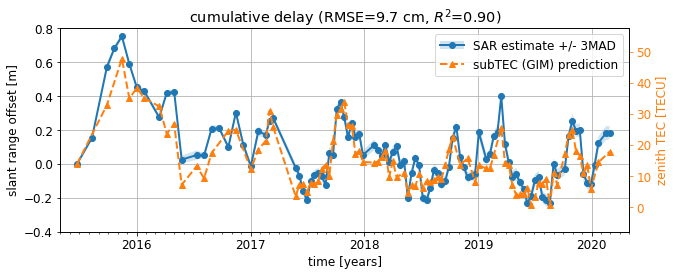

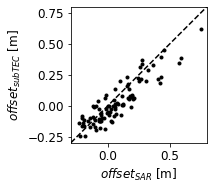

In [3]:
for key in tec.keys():
    tecType, tecSrc = key[:-3], key[-3:].upper()
    print('ionosphere: {} ({})'.format(tecType, tecSrc))

    # output filename
    out_fig_suffix = key

    # input data
    x1 = t1
    x2 = tec[key]['time']
    flag = get_common_index(x1, x2)[0]
    y1 = sar
    y1e = sar_err
    y2 = tec[key]['delay']
    y3 = tec[key]['value']

    # stats
    rmse = np.sqrt(np.sum((y2 - y1[flag])**2) / (np.sum(flag) - 1))
    r2 = stats.linregress(y2, y1[flag])[2]
    stats_msg = 'RMSE={:.1f} cm, $R^2$={:.2f}'.format(rmse*100, r2)

    ##--------------------------------- TS figure ----------------------------------##
    fig, ax = plt.subplots(figsize=fig_size)
    p0 = ax.fill_between(x1, y1 - y1e, y1 + y1e, fc='C0', ec='none', alpha=0.2)
    p1, = ax.plot(x1, y1,  '-o', color='C0', ms=6, lw=2)
    p2, = ax.plot(x2, y2, '--^', color='C1', ms=6, lw=2)

    # axis format
    ax.set_xlim(dt.datetime(2015, 5, 1), dt.datetime(2020, 5, 1))
    ax.set_ylim(-0.4, 0.8)
    ax.set_xlabel('time [years]')
    ax.set_ylabel('slant range offset [m]')
    ax.set_title('cumulative delay ({})'.format(stats_msg))
    pp.auto_adjust_xaxis_date(ax, x1, every_year=1, buffer_year=None)
    ax.grid('on')
    fig.tight_layout()
    ax.legend([(p0, p1), p2], ['SAR estimate +/- 3MAD', '{} ({}) prediction'.format(tecType, tecSrc)])

    # TEC ytick
    ax2 = ax.twinx()
    ax2.set_ylabel('zenith TEC [TECU]', color='C1')
    ax2.tick_params(which='both', axis='y', colors='C1')
    #ax2.plot(x2, y3, '--', linewidth=1, color='C2', label=tecType) # for debug
    ratio = ((np.max(y3) - np.min(y3)) / (np.max(y2) - np.min(y2)))
    y2off = dDict[tecSrc]['range_delay4Cband_'+tecType][0]
    if tecSrc == 'IGS':
        y2off *= -1
    ax2.set_ylim((ax.get_ylim() + y2off) * ratio)

    # output
    out_fig = os.path.join(work_dir, 'TS_Sen_vs_{}.png'.format(out_fig_suffix))
    print('save figure to file', out_fig)
    if save:
        plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)

    ##--------------------------------- dot figure ---------------------------------##
    ## dot figure
    plot_dot_figure(x=y1[flag], y=y2, xname='SAR', yname=tecType, vlim=(-0.3, 0.8), save=save,
                    out_fig=os.path.join(work_dir, 'DOT_Sen_vs_{}.png'.format(out_fig_suffix)))
    plt.show()

### 2.1 Residual (SAR - TEC)

save figure to file /Users/yunjunz/data/ChileSenAT149/offset_comp/boxLR/TS_res_Sen_subTEC.png


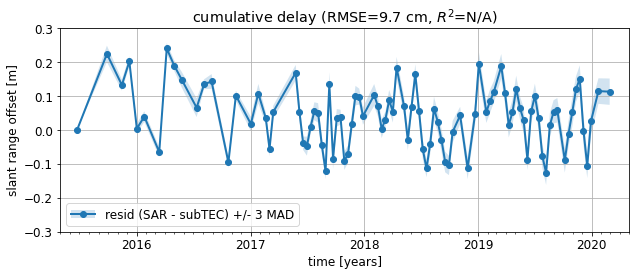

In [4]:
out_fig_suffix = 'res_Sen_{}'.format(tec_type)

## data
key = tec_type + tec_src.lower()
res = sar[flag] - tec[key]['delay']
res_err = sar_err[flag]

# stats
rmse = np.sqrt(np.sum((res - 0)**2) / (np.sum(flag) - 1))
stats_msg = 'RMSE={:.1f} cm, $R^2$=N/A'.format(rmse*100)

## plot
fig, ax = plt.subplots(figsize=fig_size)
p0, = ax.plot(x2, res,  '-o', color='C0', ms=6, lw=2)
p1  = ax.fill_between(x2, res - res_err, res + res_err, fc='C0', ec='none', alpha=0.2)

# axis format
ax.set_xlim(dt.datetime(2015, 5, 1), dt.datetime(2020, 5, 1))
ax.set_xlabel('time [years]')
ax.set_ylabel('slant range offset [m]')
ax.set_title('cumulative delay ({})'.format(stats_msg))
pp.auto_adjust_xaxis_date(ax, x1, every_year=1, buffer_year=None)
ax.grid('on')
ax.set_ylim(-0.3, 0.3)
ax.legend([(p0, p1)], ['resid (SAR - {}) +/- {} MAD'.format(tec_type, n)], loc='lower left')

# output
fig.tight_layout()
out_fig = os.path.join(work_dir, 'TS_{}.png'.format(out_fig_suffix))
print('save figure to file', out_fig)
if save:
    plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)

plt.show()

### 2.2 Residual (SAR - TEC) v.s. ERA5

save figure to file /Users/yunjunz/data/ChileSenAT149/offset_comp/boxLR/TS_res_Sen_subTEC_vs_ERA5.png
save figure to file /Users/yunjunz/data/ChileSenAT149/offset_comp/boxLR/DOT_res_Sen_subTEC_vs_ERA5.png


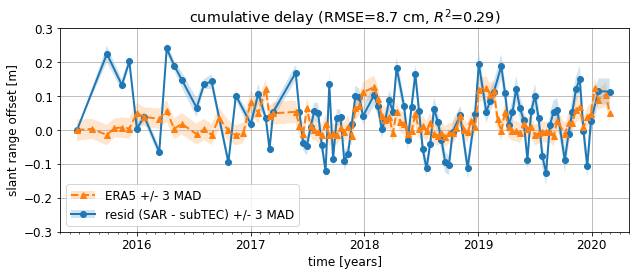

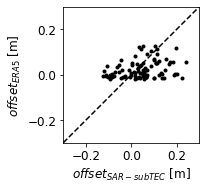

In [5]:
out_fig_suffix = 'res_Sen_{}_vs_ERA5'.format(tec_type)

## data
key = tec_type + tec_src.lower()
res = sar[flag] - tec[key]['delay']
res_err = sar_err[flag]

# stats
rmse = np.sqrt(np.sum((res - era[flag])**2) / (np.sum(flag) - 1))
r2   = stats.linregress(res, era[flag])[2]
stats_msg = 'RMSE={:.1f} cm, $R^2$={:.2f}'.format(rmse*100, r2)

## plot
fig, ax = plt.subplots(figsize=fig_size)
p0, = ax.plot(x2, res,  '-o', color='C0', ms=6, lw=2)
p2, = ax.plot(x1, era, '--^', color='C1', ms=6, lw=2)
p1  = ax.fill_between(x2, res - res_err, res + res_err, fc='C0', ec='none', alpha=0.2)
p3  = ax.fill_between(x1, era - era_err, era + era_err, fc='C1', ec='none', alpha=0.2)

# axis format
ax.set_xlim(dt.datetime(2015, 5, 1), dt.datetime(2020, 5, 1))
ax.set_ylim(-0.3, 0.3)
ax.set_xlabel('time [years]')
ax.set_ylabel('slant range offset [m]')
ax.set_title('cumulative delay ({})'.format(stats_msg))
pp.auto_adjust_xaxis_date(ax, x1, every_year=1, buffer_year=None)
ax.grid('on')
ax.legend(handles=[(p2, p3), (p0, p1)],
          labels=['ERA5 +/- {} MAD'.format(n),
                  'resid (SAR - {}) +/- {} MAD'.format(tec_type, n)],               
          loc='lower left')

# output
fig.tight_layout()
out_fig = os.path.join(work_dir, 'TS_{}.png'.format(out_fig_suffix))
print('save figure to file', out_fig)
if save:
    plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)

## dot figure
plot_dot_figure(x=res, y=era[flag], xname='SAR - {}'.format(tec_type), yname='ERA5', vlim=(-0.3, 0.3), save=save,
                out_fig=os.path.join(work_dir, 'DOT_{}.png'.format(out_fig_suffix)))
plt.show()

### 3.1 Residual (SAR - TEC - ERA5)

save figure to file /Users/yunjunz/data/ChileSenAT149/offset_comp/boxLR/TS_res_Sen_subTEC_ERA5.png


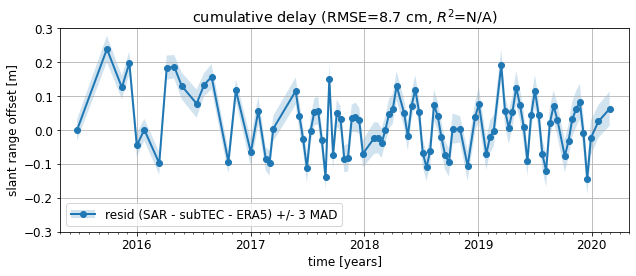

In [6]:
out_fig_suffix = 'res_Sen_{}_ERA5'.format(tec_type)

## data
key = tec_type + tec_src.lower()
res = sar[flag] - tec[key]['delay'] - era[flag]
res_err = (sar_err[flag]**2 + era_err[flag]**2) ** 0.5

# stats
rmse = np.sqrt(np.sum(res**2) / (np.sum(flag) - 1))
stats_msg = 'RMSE={:.1f} cm, $R^2$=N/A'.format(rmse*100)

## plot
fig, ax = plt.subplots(figsize=fig_size)
p0, = ax.plot(x2, res,  '-o', color='C0', ms=6, lw=2)
p1  = ax.fill_between(x2, res - res_err, res + res_err, fc='C0', ec='none', alpha=0.2)

# axis format
ax.set_xlim(dt.datetime(2015, 5, 1), dt.datetime(2020, 5, 1))
ax.set_ylim(-0.3, 0.3)
ax.set_xlabel('time [years]')
ax.set_ylabel('slant range offset [m]')
ax.set_title('cumulative delay ({})'.format(stats_msg))
pp.auto_adjust_xaxis_date(ax, x1, every_year=1, buffer_year=None)
ax.grid('on')
ax.legend([(p0, p1)], ['resid (SAR - {} - ERA5) +/- {} MAD'.format(tec_type, n)], loc='lower left')

# output
fig.tight_layout()
out_fig = os.path.join(work_dir, 'TS_{}.png'.format(out_fig_suffix))
print('save figure to file', out_fig)
if save:
    plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

### 3.2 Residual (SAR - TEC - ERA5) v.s. SET

Stats for S1A only:  RMSE=8.0 cm, R^2=0.65
Stats for S1B only:  RMSE=5.4 cm, R^2=0.74
save figure to file /Users/yunjunz/data/ChileSenAT149/offset_comp/boxLR/TS_res_Sen_subTEC_ERA5_vs_SET.png
save figure to file /Users/yunjunz/data/ChileSenAT149/offset_comp/boxLR/DOT_res_Sen_subTEC_ERA5_vs_SET.png


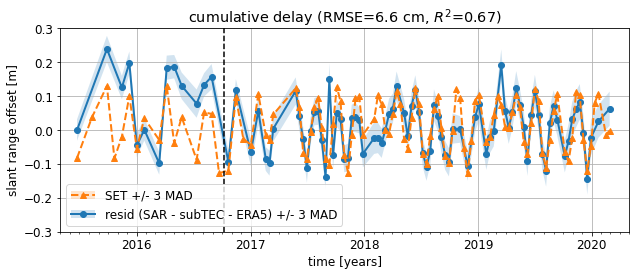

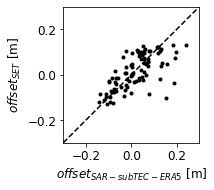

In [7]:
out_fig_suffix = 'res_Sen_{}_ERA5_vs_SET'.format(tec_type)

## data
key = tec_type + tec_src.lower()
res = sar[flag] - tec[key]['delay'] - era[flag]
res_err = (sar_err[flag]**2 + era_err[flag]**2) ** 0.5

# stats for S1A only
flag_a = x2 < dt_s1ab
sld -= np.median((sld[flag] - res)[flag_a])
rmse_a = np.sqrt(np.sum((res - sld[flag])[flag_a]**2) / (np.sum(flag_a) - 1))
r2_a   = stats.linregress(res[flag_a], sld[flag][flag_a])[2]
print('Stats for S1A only:  RMSE={:.1f} cm, R^2={:.2f}'.format(rmse_a*100, r2_a))

# stats for S1B only
flag_b = x2 > dt_s1ab
sld -= np.median((sld[flag] - res)[flag_b])
rmse_b = np.sqrt(np.sum((res - sld[flag])[flag_b]**2) / (np.sum(flag_b) - 1))
r2_b   = stats.linregress(res[flag_b], sld[flag][flag_b])[2]
print('Stats for S1B only:  RMSE={:.1f} cm, R^2={:.2f}'.format(rmse_b*100, r2_b))

# stats
sld -= np.median(sld[flag] - res)
rmse = np.sqrt(np.sum((res - sld[flag])**2) / (np.sum(flag) - 1))
r2   = stats.linregress(res, sld[flag])[2]
stats_msg = 'RMSE={:.1f} cm, $R^2$={:.2f}'.format(rmse*100, r2)


## plot
fig, ax = plt.subplots(figsize=fig_size)
p0, = ax.plot(x2, res,  '-o', color='C0', ms=6, lw=2)
p2, = ax.plot(x1, sld, '--^', color='C1', ms=6, lw=2)
p1  = ax.fill_between(x2, res - res_err, res + res_err, fc='C0', ec='none', alpha=0.2)
p3  = ax.fill_between(x1, sld - sld_err, sld + sld_err, fc='C1', ec='none', alpha=0.2)

# axis format
ax.axvline(x=dt_s1ab, linestyle='--', color='k')   # S1A / S1B
ax.set_xlim(dt.datetime(2015, 5, 1), dt.datetime(2020, 5, 1))
ax.set_ylim(-0.3, 0.3)
ax.set_xlabel('time [years]')
ax.set_ylabel('slant range offset [m]')
ax.set_title('cumulative delay ({})'.format(stats_msg))
pp.auto_adjust_xaxis_date(ax, x1, every_year=1, buffer_year=None)
ax.grid('on')
ax.legend(handles=[(p2, p3), (p0, p1)],
          labels=['SET +/- {} MAD'.format(n),
                  'resid (SAR - {} - ERA5) +/- {} MAD'.format(tec_type, n)],
          loc='lower left')

# output
fig.tight_layout()
out_fig = os.path.join(work_dir, 'TS_{}.png'.format(out_fig_suffix))
print('save figure to file', out_fig)
if save:
    plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)

## dot figure
plot_dot_figure(x=res, y=sld[flag], xname='SAR - {} - ERA5'.format(tec_type), yname='SET', vlim=(-0.3, 0.3), save=save,
                out_fig=os.path.join(work_dir, 'DOT_{}.png'.format(out_fig_suffix)))
plt.show()

### 4.1 Residual (SAR - TEC - ERA5 - SET)

save figure to file /Users/yunjunz/data/ChileSenAT149/offset_comp/boxLR/TS_res_Sen_subTEC_ERA5_SET.png


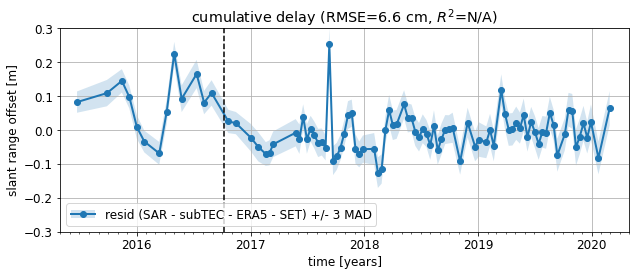

In [8]:
out_fig_suffix = 'res_Sen_{}_ERA5_SET'.format(tec_type)

## data
key = tec_type + tec_src.lower()
res = sar[flag] - tec[key]['delay'] - era[flag] - sld[flag]
res_err = (sar_err[flag]**2 + era_err[flag]**2 + sld_err[flag]**2) ** 0.5

# stats
rmse = np.sqrt(np.sum(res**2) / (np.sum(flag) - 1))
stats_msg = 'RMSE={:.1f} cm, $R^2$=N/A'.format(rmse*100)

## plot
fig, ax = plt.subplots(figsize=fig_size)
p0, = ax.plot(x2, res,  '-o', color='C0', ms=6, lw=2)
p1  = ax.fill_between(x2, res - res_err, res + res_err, fc='C0', ec='none', alpha=0.2)

# axis format
ax.axvline(x=dt_s1ab, linestyle='--', color='k')   # S1A / S1B
ax.set_xlim(dt.datetime(2015, 5, 1), dt.datetime(2020, 5, 1))
ax.set_ylim(-0.3, 0.3)
ax.set_xlabel('time [years]')
ax.set_ylabel('slant range offset [m]')
ax.set_title('cumulative delay ({})'.format(stats_msg))
pp.auto_adjust_xaxis_date(ax, x1, every_year=1, buffer_year=None)
ax.grid('on')
ax.legend([(p0, p1)], ['resid (SAR - {} - ERA5 - SET) +/- {} MAD'.format(tec_type, n)], loc='lower left')

# output
fig.tight_layout()
out_fig = os.path.join(work_dir, 'TS_{}.png'.format(out_fig_suffix))
print('save figure to file', out_fig)
if save:
    plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

### 4.2 Residual (SAR - TEC - ERA5 - SET) vs. TEC-SAR distance

save figure to file /Users/yunjunz/data/ChileSenAT149/offset_comp/boxLR/TS_res_Sen_subTEC_ERA5_SET_vs_dist.png


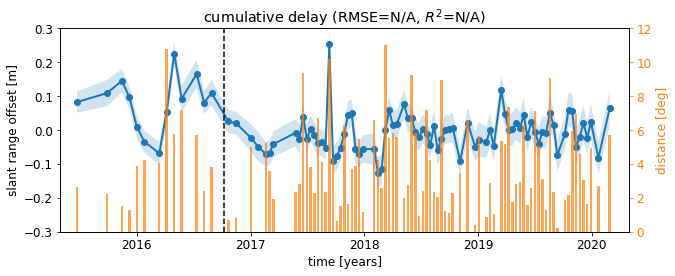

In [18]:
out_fig_suffix = 'res_Sen_{}_ERA5_SET_vs_dist'.format(tec_type)

## data
key = tec_type + tec_src.lower()
res = sar[flag] - tec[key]['delay'] - era[flag] - sld[flag]
res_err = (sar_err[flag]**2 + era_err[flag]**2 + sld_err[flag]**2) ** 0.5
dist = np.array(dDict['GIM']['dist_deg'])

## plot
fig, ax = plt.subplots(figsize=[9, 4])

p0, = ax.plot(x2, res,  '-o', color='C0', ms=6, lw=2)
p1  = ax.fill_between(x2, res - res_err, res + res_err, fc='C0', ec='none', alpha=0.2)
# axis format
ax.axvline(x=dt_s1ab, linestyle='--', color='k')   # S1A / S1B
ax.set_xlim(dt.datetime(2015, 5, 1), dt.datetime(2020, 5, 1))
ax.set_ylim(-0.3, 0.3)
ax.set_xlabel('time [years]')
ax.set_ylabel('slant range offset [m]')
ax.set_title('cumulative delay (RMSE=N/A, $R^2$=N/A)')
#ax.legend([(p0, p1)], ['resid (SAR - {} - ERA5 - SET) +/- {} MAD'.format(tec_type, n)], loc='upper right')
fig.tight_layout()

ax2 = ax.twinx()
ax2.bar(x2, dist, width=8, color='C1', label='dist', alpha=0.7)
# axis format
ax2.tick_params(which='both', axis='y', colors='C1')
ax2.set_ylim(0, 12)
ax2.set_ylabel('distance [deg]', color='C1')

# output
out_fig = os.path.join(work_dir, 'TS_{}.png'.format(out_fig_suffix))
print('save figure to file', out_fig)
if save:
    plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

### 5. Differential TS: residual (SAR - TEC - ERA5) v.s. SET

res min/max: -0.3/0.3 cm
sld min/max: -0.2/0.2 cm
save figure to file /Users/yunjunz/data/ChileSenAT149/offset_comp/boxLR/TS_diff_res_Sen_subTEC_ERA5_vs_SET.png
save figure to file /Users/yunjunz/data/ChileSenAT149/offset_comp/boxLR/DOT_diff_res_Sen_subTEC_ERA5_vs_SET.png


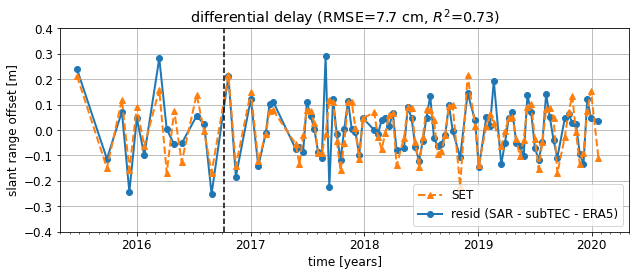

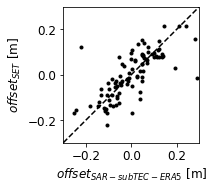

In [10]:
out_fig_suffix = 'diff_res_Sen_{}_ERA5_vs_SET'.format(tec_type)

## data
key = tec_type + tec_src.lower()
res_diff = sar[flag] - tec[key]['delay'] - era[flag]
sld_diff = np.array(dDict['SET']['range_delay_SET_med'])[flag] * -1    # predicted offset from SET
sld_diff -= np.median(sld_diff - res_diff)

ref_diff = np.diff(res_diff)
sld_diff = np.diff(sld_diff)

# stats
rmse = np.sqrt(np.sum((ref_diff - sld_diff)**2) / (np.sum(flag) - 2))
r2   = stats.linregress(ref_diff, sld_diff)[2]
stats_msg = 'RMSE={:.1f} cm, $R^2$={:.2f}'.format(rmse*100, r2)
print('res min/max: {:.1f}/{:.1f} cm'.format(np.min(ref_diff), np.max(ref_diff)))
print('sld min/max: {:.1f}/{:.1f} cm'.format(np.min(sld_diff), np.max(sld_diff)))

## plot
fig, ax = plt.subplots(figsize=fig_size)
p0, = ax.plot(x2[:-1], ref_diff,  '-o', color='C0', ms=6, lw=2)
p2, = ax.plot(x2[:-1], sld_diff, '--^', color='C1', ms=6, lw=2)

# axis format
ax.axvline(x=dt_s1ab, linestyle='--', color='k')   # S1A / S1B
ax.set_xlim(dt.datetime(2015, 5, 1), dt.datetime(2020, 5, 1))
ax.set_ylim(-0.4, 0.4)
ax.set_xlabel('time [years]')
ax.set_ylabel('slant range offset [m]')
ax.set_title('differential delay ({})'.format(stats_msg))
pp.auto_adjust_xaxis_date(ax, x2[:-1], every_year=1, buffer_year=None)
ax.grid('on')
ax.legend(handles=[p2, p0],
          labels=['SET'.format(n),
                  'resid (SAR - {} - ERA5)'.format(tec_type, n)],
          loc='lower right')

# output
fig.tight_layout()
out_fig = os.path.join(work_dir, 'TS_{}.png'.format(out_fig_suffix))
print('save figure to file', out_fig)
if save:
    plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)

## dot figure
plot_dot_figure(x=ref_diff, y=sld_diff, xname='SAR - {} - ERA5'.format(tec_type), yname='SET', vlim=(-0.3, 0.3), save=save,
                out_fig=os.path.join(work_dir, 'DOT_{}.png'.format(out_fig_suffix)))
plt.show()